# Introduction #

Доброго дня!

Меня зовут **Васюхин Артём**, я студент XV когорты курса DS+ "Яндекс.Практикум" и в этом проекте мы рассмотрим данные о сердечно-сосудистых заболеваниях (далее - ССЗ), которые продолжают оставаться главной причиной смертности во всём мире.

**Наша задача** - создать модель, которая бы на основе данных анализов предсказывала вероятность возникновения ССЗ у пациента.

## Import libraries and previous data checking ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve

import joblib

In [2]:
test_data = pd.read_csv('test_hdp.csv')
train_data = pd.read_csv('train_hdp.csv')
subsample = pd.read_csv('sample_submission.csv')

display(train_data.head())
display(test_data.head())

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,18888,1,154,85.0,130,80,1,1,0,0,1
1,6,19042,2,170,69.0,130,90,1,1,0,0,1
2,7,20432,1,160,70.0,120,75,1,1,0,0,0
3,10,18133,2,185,94.0,130,90,1,1,0,0,1
4,11,16093,2,170,76.0,120,80,1,1,0,0,1


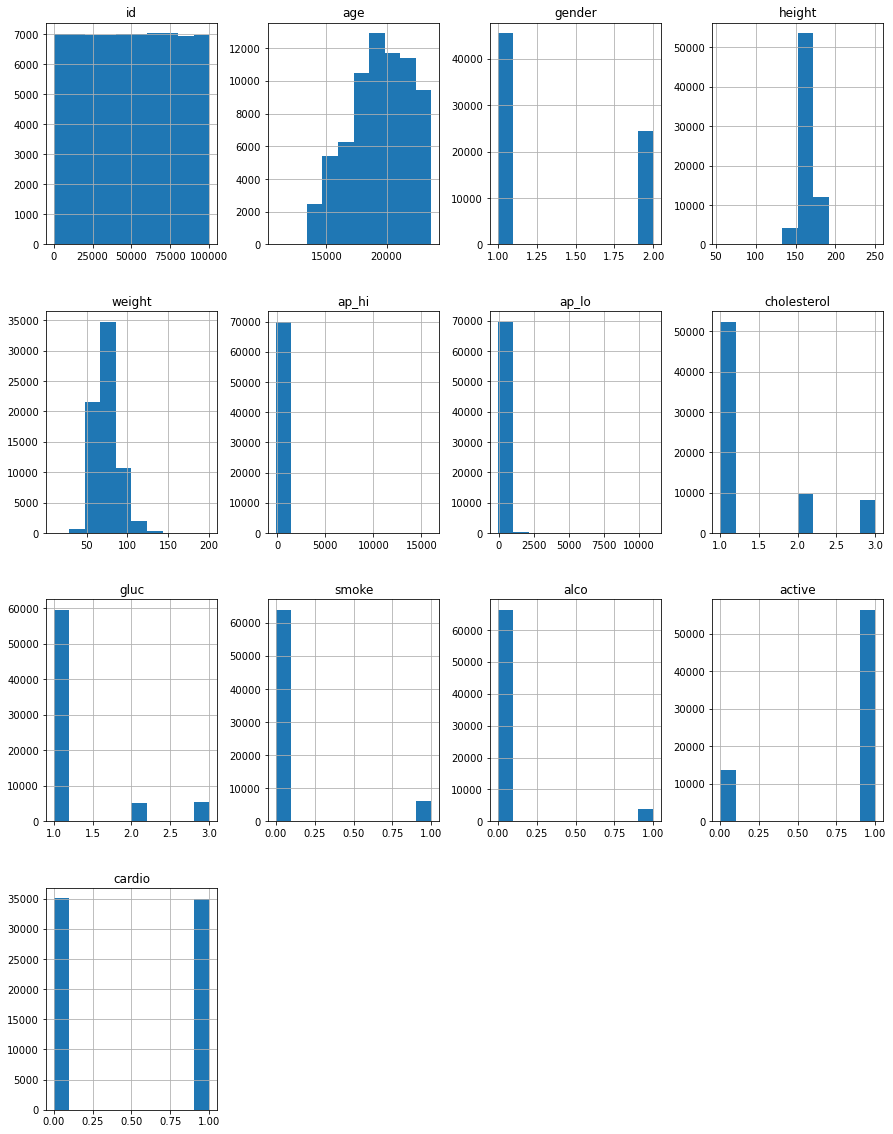

In [3]:
train_data.hist(figsize=(15,20));

# EDA #

In [4]:
train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
train_data['weight'] = train_data['weight'].astype('int64')
train_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62,110,80,1,1,0,0,1,0
1,1,20228,1,156,85,140,90,3,1,0,0,1,1
2,2,18857,1,165,64,130,70,3,1,0,0,0,1
3,3,17623,2,169,82,150,100,1,1,0,0,1,1
4,4,17474,1,156,56,100,60,1,1,0,0,0,0


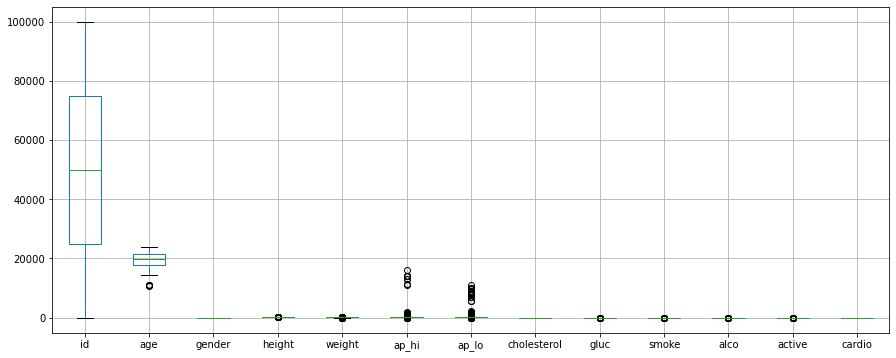

In [6]:
train_data.boxplot(figsize=(15,6));

## id ##

In [7]:
# удалим ненужную колонку id
train_data = train_data.drop('id', axis=1)
test_data = test_data.drop('id', axis=1)

display(train_data.head(5))
display(test_data.head(5))

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62,110,80,1,1,0,0,1,0
1,20228,1,156,85,140,90,3,1,0,0,1,1
2,18857,1,165,64,130,70,3,1,0,0,0,1
3,17623,2,169,82,150,100,1,1,0,0,1,1
4,17474,1,156,56,100,60,1,1,0,0,0,0


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,18888,1,154,85.0,130,80,1,1,0,0,1
1,19042,2,170,69.0,130,90,1,1,0,0,1
2,20432,1,160,70.0,120,75,1,1,0,0,0
3,18133,2,185,94.0,130,90,1,1,0,0,1
4,16093,2,170,76.0,120,80,1,1,0,0,1


## age ##

In [8]:
def boxplot_col(column):
    train_data.boxplot(column, figsize=(10, 5));
    return boxplot_col

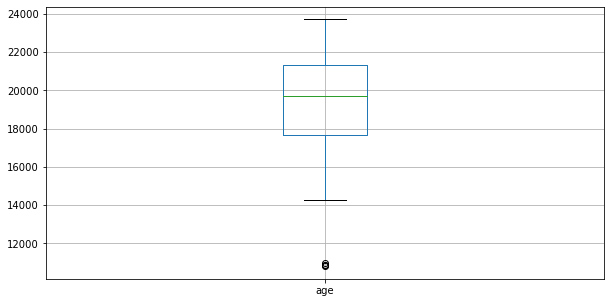

In [9]:
boxplot_col('age');

In [10]:
train_data.query('age < 12000')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
6219,10878,1,175,59,120,80,1,1,0,0,1,0
22343,10798,2,175,92,100,60,1,1,0,0,1,0
30666,10859,1,159,59,120,80,1,1,0,0,1,0
55905,10964,1,160,59,110,70,1,1,0,0,1,0


In [11]:
train_data = train_data.query('age > 12000')

In [12]:
train_data['age'] = (train_data['age'] / 365).astype('int')
test_data['age'] = (test_data['age'] / 365).astype('int')
train_data

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62,110,80,1,1,0,0,1,0
1,55,1,156,85,140,90,3,1,0,0,1,1
2,51,1,165,64,130,70,3,1,0,0,0,1
3,48,2,169,82,150,100,1,1,0,0,1,1
4,47,1,156,56,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,52,2,168,76,120,80,1,1,1,0,1,0
69996,61,1,158,126,140,90,2,2,0,0,1,1
69997,52,2,183,105,180,90,3,1,0,1,0,1
69998,61,1,163,72,135,80,1,2,0,0,0,1


<AxesSubplot:>

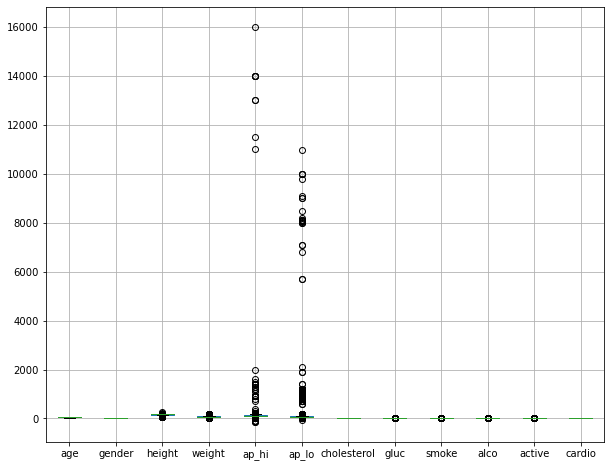

In [13]:
train_data.boxplot(figsize=(10,8))

## ap_hi ##

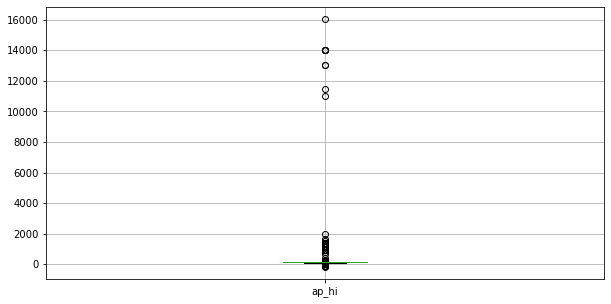

In [14]:
boxplot_col('ap_hi');

In [15]:
train_data.query('ap_hi > 300')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
1876,41,1,160,60,902,60,1,1,0,0,1,0
2014,62,2,167,59,906,0,1,1,0,0,1,0
4817,39,1,168,63,909,60,2,1,0,0,1,0
7763,57,1,175,80,11500,90,1,1,0,0,1,1
8915,51,1,164,75,1420,80,2,1,0,0,1,1
9557,62,1,155,87,701,110,1,1,0,0,1,1
13895,43,1,168,72,1500,80,1,1,0,0,1,1
17713,61,2,163,50,907,70,3,3,0,0,1,1
23867,44,1,161,92,906,0,2,1,0,0,1,1
25464,43,2,169,75,14020,80,2,1,0,0,1,1


In [16]:
train_data.query('ap_hi < 300').sort_values(by='ap_hi', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
67710,53,2,168,75,240,140,3,1,0,0,1,1
69329,54,1,145,62,240,130,1,1,0,0,0,1
42725,50,2,165,76,240,100,1,1,0,0,1,1
32560,58,2,176,98,240,110,1,1,1,0,1,1
26053,61,1,166,102,240,130,2,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
16021,60,2,161,90,-115,70,1,1,0,0,1,0
25240,40,2,168,50,-120,80,2,1,0,0,0,1
46627,64,2,160,59,-120,80,1,1,0,0,0,0
23988,50,1,162,74,-140,90,1,1,0,0,1,1


In [17]:
train_data['ap_hi'] = train_data['ap_hi'].abs()
test_data['ap_hi'] = test_data['ap_hi'].abs()

train_data.query('ap_hi <= 0')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio


In [18]:
train_data.query('ap_hi < 300').sort_values(by='ap_hi', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
26053,61,1,166,102,240,130,2,1,0,0,1,1
56014,60,2,176,115,240,110,1,1,0,0,1,0
32560,58,2,176,98,240,110,1,1,1,0,1,1
69329,54,1,145,62,240,130,1,1,0,0,0,1
67710,53,2,168,75,240,140,3,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
56777,50,1,160,80,10,80,1,1,0,0,1,1
62817,50,1,155,79,10,70,1,1,0,0,1,0
5382,58,1,162,69,7,80,1,1,0,0,1,0
42334,51,1,171,80,1,1088,1,1,0,0,1,1


In [19]:
train_data.query('ap_hi < 50').sort_values(by='ap_hi', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
52851,48,2,164,64,24,20,3,1,0,0,1,1
17872,55,2,181,79,20,80,1,1,0,0,1,1
31315,62,1,163,115,20,170,1,1,0,0,1,1
37329,51,2,175,104,20,90,1,2,0,0,1,1
24850,57,2,170,100,20,80,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
56777,50,1,160,80,10,80,1,1,0,0,1,1
57909,44,1,165,56,10,60,1,1,0,0,1,0
5382,58,1,162,69,7,80,1,1,0,0,1,0
8757,46,2,163,63,1,2088,1,1,1,0,1,0


In [20]:
# удаляем строки с неподдающимися анализу значениями ap_lo
train_data['ap_hi'] = train_data['ap_hi'].drop([8757, 42334, 5382], axis=0)

# домножим значения <50 на 10
train_data.loc[train_data['ap_hi'] < 50, 'ap_hi'] = train_data['ap_hi'] * 10
test_data.loc[test_data['ap_hi'] < 50, 'ap_hi'] = test_data['ap_hi'] * 10

# зададим условие, при котором строки с ap_hi <40 не будут учитываться
train_data = train_data.query('ap_hi > 40')

# переведем значения в целочисленные
train_data['ap_hi'] = train_data['ap_hi'].astype('int64')
test_data['ap_hi'] = test_data['ap_hi'].astype('int64')

C:\Users\Home\AppData\Local\Temp\ipykernel_7324\2892848336.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['ap_hi'] = train_data['ap_hi'].astype('int64')


In [21]:
# убираем строки с ap_hi > 210
train_data = train_data.query('ap_hi < 210')

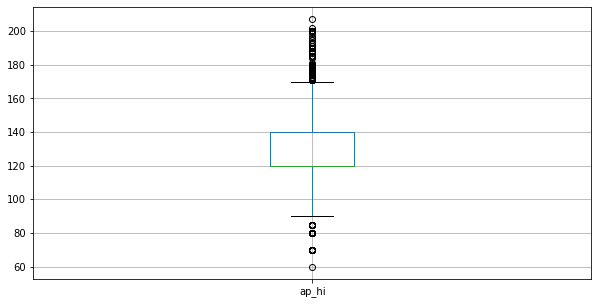

In [22]:
boxplot_col('ap_hi');

In [23]:
train_data.sort_values(by='ap_hi', ascending=False).tail(25)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
34516,41,1,157,47,80,60,1,1,0,0,1,0
46160,42,1,156,62,80,60,1,1,0,0,0,0
29985,58,1,163,102,80,120,1,1,0,0,1,1
59958,40,1,167,62,80,60,1,1,0,0,0,0
61380,45,1,163,78,80,60,2,2,0,0,1,1
57331,49,2,173,100,80,60,1,1,0,0,1,0
38730,45,1,149,51,70,120,1,1,0,0,1,0
32733,57,2,164,70,70,100,1,1,0,0,0,0
45951,42,1,158,47,70,40,1,1,0,0,1,0
40454,56,1,164,62,70,1100,1,1,0,0,0,0


**Ремарка**: здесь мы видим, что некоторые значения в ap_hi меньше, чем в ap_lo. Предположим, что они перепутаны местами, поэтому вернёмся к ним позже - после работы с колонкой ap_lo.

## ap_lo ##

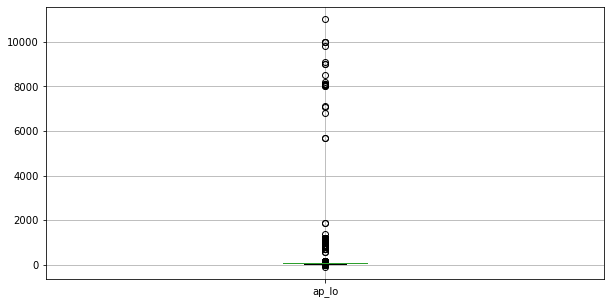

In [24]:
boxplot_col('ap_lo');

In [25]:
train_data.query('ap_lo >= 2000')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
2381,57,2,186,105,140,10000,1,1,0,0,1,1
2985,55,1,168,78,140,8044,3,3,0,0,0,1
6653,53,1,162,69,130,9100,1,1,0,0,1,1
9165,52,1,165,71,120,8000,1,1,0,0,1,1
12086,58,2,169,78,130,9011,1,1,1,1,1,1
14308,50,1,160,70,160,7100,1,1,0,1,1,1
15990,39,2,179,70,120,8500,1,1,0,0,1,0
17738,53,1,151,57,140,8099,1,1,0,0,0,0
20882,52,1,155,81,160,8100,1,1,0,0,1,1
23230,54,2,170,70,112,5700,1,2,0,0,1,1


In [26]:
train_data.loc[train_data['ap_lo'] > 500, 'ap_lo'] = train_data['ap_lo'] / 100
test_data.loc[test_data['ap_lo'] > 500, 'ap_lo'] = test_data['ap_lo'] / 100

train_data.query('ap_lo > 500')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio


<function __main__.boxplot_col(column)>

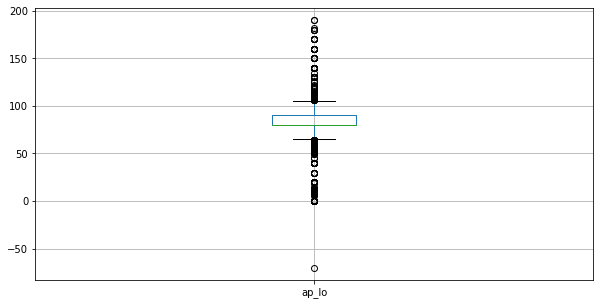

In [27]:
boxplot_col('ap_lo')

In [28]:
train_data.query('ap_lo < 0')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
60106,61,1,167,74,150,-70.0,1,1,0,0,1,1


In [29]:
train_data['ap_lo'] = train_data['ap_lo'].abs()
test_data['ap_lo'] = test_data['ap_lo'].abs()

In [30]:
train_data.query('ap_lo == 0').sort_values(by='ap_lo', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
13489,41,2,150,60,130,0.0,1,1,0,0,0,0
16459,56,1,156,50,138,0.0,3,1,0,0,1,1
17381,49,1,164,78,138,0.0,1,1,0,0,1,0
22923,58,2,166,68,149,0.0,1,1,0,0,1,1
25454,49,2,176,73,120,0.0,1,1,0,0,1,0
27686,64,2,180,73,140,0.0,1,1,1,1,1,1
38370,63,2,170,81,148,0.0,1,1,0,0,1,0
43922,51,1,164,78,108,0.0,2,1,0,0,1,0
45835,53,2,165,70,140,0.0,3,1,1,0,1,0
48049,52,1,160,84,121,0.0,1,1,0,0,0,1


In [31]:
train_data = train_data.query('ap_lo > 0')

In [32]:
train_data.query('ap_lo <= 15').sort_values(by='ap_lo', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
56927,50,1,155,76,70,15.00,1,1,0,1,1,1
49217,43,1,163,77,200,14.00,1,1,0,0,1,1
59433,63,1,158,89,176,12.11,3,2,0,1,1,1
67474,53,1,161,93,160,12.00,3,1,0,0,0,1
25696,52,1,146,74,180,12.00,2,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
69320,57,2,168,63,120,6.02,1,1,0,0,0,0
68568,42,1,163,71,110,6.00,1,1,0,0,1,0
28065,55,1,161,52,90,6.00,1,1,0,0,1,0
64409,57,2,173,94,130,5.85,2,1,0,0,1,1


In [33]:
train_data.loc[train_data['ap_lo'] <= 21, 'ap_lo'] = train_data['ap_lo'] * 10
test_data.loc[test_data['ap_lo'] <= 21, 'ap_lo'] = test_data['ap_lo'] * 10

train_data.query('ap_lo <= 15').sort_values(by='ap_lo', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
35140,57,1,146,55,130,10.0,1,1,0,0,0,0


In [34]:
train_data.query('ap_lo <= 50').sort_values(by='ap_lo', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
383,53,1,147,41,80,50.0,1,1,0,0,1,0
45554,47,1,156,55,90,50.0,1,1,0,0,1,1
32422,39,1,152,40,90,50.0,1,1,0,0,1,0
32679,53,1,160,58,127,50.0,1,1,0,0,1,0
34104,53,1,165,62,90,50.0,3,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
33262,55,2,174,91,120,30.0,1,1,0,0,1,1
5333,57,1,164,102,120,30.0,2,1,0,0,1,0
418,45,1,157,72,150,30.0,1,1,0,0,1,1
36958,49,1,171,82,160,30.0,1,1,0,0,0,1


In [35]:
train_data = train_data.query('ap_lo >= 40')

train_data.query('ap_lo <= 50').sort_values(by = 'ap_lo', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
383,53,1,147,41,80,50.0,1,1,0,0,1,0
45554,47,1,156,55,90,50.0,1,1,0,0,1,1
32679,53,1,160,58,127,50.0,1,1,0,0,1,0
34104,53,1,165,62,90,50.0,3,1,0,0,1,1
481,53,1,158,86,160,50.0,2,3,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
46155,53,2,175,73,130,40.0,1,1,0,0,0,0
45951,42,1,158,47,70,40.0,1,1,0,0,1,0
42446,62,2,166,98,130,40.0,1,1,0,0,1,1
43137,60,1,170,120,160,40.0,3,3,0,0,1,1


In [36]:
train_data.loc[
    (train_data['ap_lo'] <= 50) & 
    (train_data['ap_hi'] > 100), 
    'ap_lo'] = train_data['ap_lo'].drop(train_data.index, axis=0)

In [37]:
train_data.query('ap_lo <= 50').sort_values(by = 'ap_lo', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
383,53,1,147,41,80,50.0,1,1,0,0,1,0
1960,47,1,155,50,90,50.0,1,1,0,0,1,0
35047,46,2,172,58,100,50.0,1,1,1,0,1,0
38103,59,1,164,58,90,50.0,1,1,0,0,1,0
39718,51,1,162,51,90,50.0,1,1,0,0,0,0
41727,39,1,161,46,80,50.0,1,1,0,0,0,0
43233,49,2,172,75,80,50.0,2,2,0,0,1,1
45320,47,1,160,47,90,50.0,2,1,0,0,1,0
45554,47,1,156,55,90,50.0,1,1,0,0,1,1
45556,48,1,157,57,90,50.0,1,1,0,0,1,0


**Теперь вернёмся к нашей гипотезе, при которой в некоторых случаях значения ap_hi и ap_lo перепутаны.**

In [38]:
train_data.query('ap_hi < ap_lo')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
474,52,1,156,65,120,150.0,2,1,0,0,1,0
636,56,2,169,68,70,110.0,1,1,0,0,1,0
2384,64,1,154,102,90,150.0,1,1,0,0,0,1
2990,60,2,182,90,80,140.0,3,3,0,0,1,1
3447,54,2,180,80,80,125.0,3,3,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
66657,53,2,160,81,80,120.0,3,3,1,1,1,1
67421,64,1,153,74,80,130.0,1,1,0,0,1,1
67470,58,2,172,57,80,120.0,1,1,1,0,1,1
68067,50,1,152,65,80,120.0,1,1,0,0,1,0


**Пофиксить**

In [39]:
# вар.1: удаляем строки, где ap_lo > ap_hi
train_data = train_data.query('ap_hi > ap_lo')

<function __main__.boxplot_col(column)>

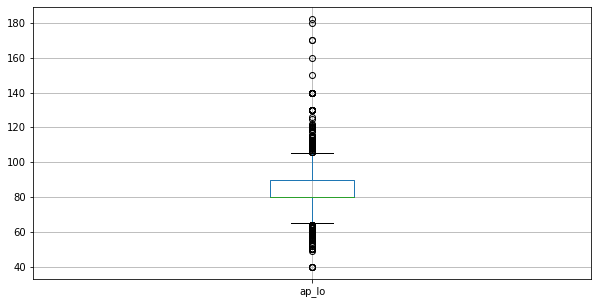

In [40]:
boxplot_col('ap_lo')

In [41]:
train_data = train_data.query('ap_lo <= 140')

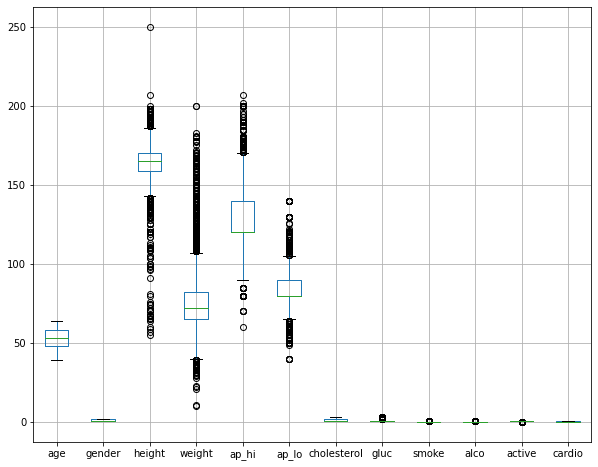

In [42]:
train_data.boxplot(figsize=(10,8));

## height ##

<function __main__.boxplot_col(column)>

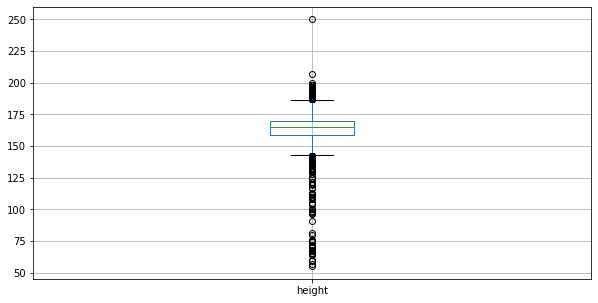

In [43]:
boxplot_col('height')

In [44]:
train_data.query('height > 215 or height < 100').sort_values(by='height')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
22723,64,1,55,81,130,90.0,1,1,0,0,1,1
66643,51,1,57,61,130,90.0,1,1,0,0,1,1
64115,50,1,59,57,125,67.0,1,1,0,0,0,0
29157,52,1,60,69,110,70.0,1,1,0,0,0,0
27603,57,1,64,61,130,70.0,1,1,0,0,1,0
44490,52,1,65,60,120,80.0,1,1,0,0,1,0
33607,53,2,65,72,130,80.0,1,1,0,0,0,0
64454,58,1,66,63,120,80.0,1,1,0,0,0,1
14323,60,1,67,57,120,90.0,1,1,0,0,1,1
53344,56,2,67,80,120,80.0,1,1,0,0,0,1


In [45]:
train_data = train_data.query('height > 120 & height < 225')

<function __main__.boxplot_col(column)>

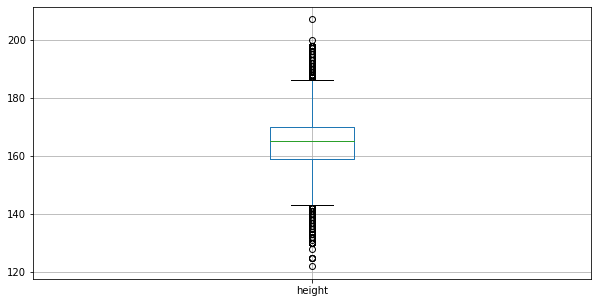

In [46]:
boxplot_col('height')

In [47]:
train_data['ap_lo'] = train_data['ap_lo'].astype('int64')
train_data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62,110,80,1,1,0,0,1,0
1,55,1,156,85,140,90,3,1,0,0,1,1
2,51,1,165,64,130,70,3,1,0,0,0,1
3,48,2,169,82,150,100,1,1,0,0,1,1
4,47,1,156,56,100,60,1,1,0,0,0,0


## weight ##

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69622 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          69622 non-null  int32
 1   gender       69622 non-null  int64
 2   height       69622 non-null  int64
 3   weight       69622 non-null  int64
 4   ap_hi        69622 non-null  int64
 5   ap_lo        69622 non-null  int64
 6   cholesterol  69622 non-null  int64
 7   gluc         69622 non-null  int64
 8   smoke        69622 non-null  int64
 9   alco         69622 non-null  int64
 10  active       69622 non-null  int64
 11  cardio       69622 non-null  int64
dtypes: int32(1), int64(11)
memory usage: 6.6 MB


<function __main__.boxplot_col(column)>

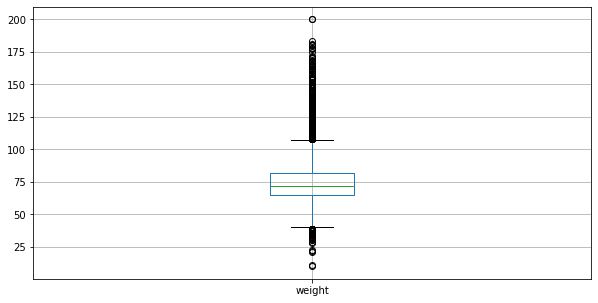

In [48]:
train_data.info()
boxplot_col('weight')

In [49]:
train_data.query('weight >= 150 & cardio == 0')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
389,45,2,165,169,120,80,1,1,0,0,1,0
435,45,1,186,200,130,70,1,1,0,0,0,0
2458,64,2,159,165,130,70,1,1,0,0,0,0
3413,39,1,159,159,100,80,1,1,0,0,1,0
4004,57,1,176,150,160,110,2,1,0,0,0,0
8423,40,1,170,165,120,80,1,1,0,0,1,0
14520,60,1,170,165,120,80,1,1,0,0,1,0
16384,49,2,170,156,150,90,1,3,0,0,0,0
18641,40,2,178,152,140,90,2,2,0,0,1,0
20092,56,2,165,178,120,80,1,1,1,1,1,0


In [50]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69622 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          69622 non-null  int32
 1   gender       69622 non-null  int64
 2   height       69622 non-null  int64
 3   weight       69622 non-null  int64
 4   ap_hi        69622 non-null  int64
 5   ap_lo        69622 non-null  int64
 6   cholesterol  69622 non-null  int64
 7   gluc         69622 non-null  int64
 8   smoke        69622 non-null  int64
 9   alco         69622 non-null  int64
 10  active       69622 non-null  int64
 11  cardio       69622 non-null  int64
dtypes: int32(1), int64(11)
memory usage: 6.6 MB


In [51]:
train_data.loc[
    (train_data['weight'] >= 150) & 
    (train_data['cardio'] == 0)] = train_data.drop(train_data.index, axis=0)

In [52]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69622 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69603 non-null  float64
 1   gender       69603 non-null  float64
 2   height       69603 non-null  float64
 3   weight       69603 non-null  float64
 4   ap_hi        69603 non-null  float64
 5   ap_lo        69603 non-null  float64
 6   cholesterol  69603 non-null  float64
 7   gluc         69603 non-null  float64
 8   smoke        69603 non-null  float64
 9   alco         69603 non-null  float64
 10  active       69603 non-null  float64
 11  cardio       69603 non-null  float64
dtypes: float64(12)
memory usage: 8.9 MB


In [53]:
train_data.query('weight >= 150 & cardio == 0')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio


<function __main__.boxplot_col(column)>

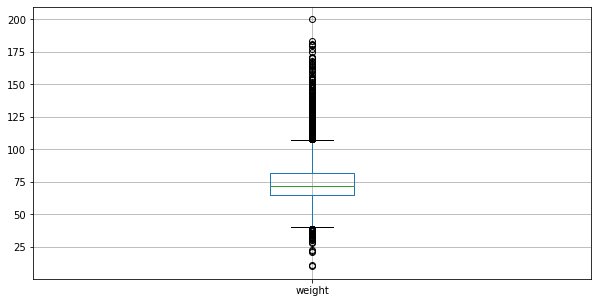

In [54]:
boxplot_col('weight')

In [55]:
train_data.query('weight < 35')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
14722,62.0,1.0,143.0,34.0,100.0,70.0,1.0,1.0,0.0,0.0,1.0,0.0
16906,47.0,2.0,170.0,31.0,150.0,90.0,2.0,2.0,0.0,0.0,1.0,1.0
18559,49.0,1.0,160.0,30.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0,1.0
22016,42.0,1.0,146.0,32.0,100.0,70.0,1.0,1.0,0.0,0.0,0.0,0.0
26806,63.0,1.0,157.0,23.0,110.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0
29488,55.0,2.0,177.0,22.0,120.0,80.0,1.0,1.0,1.0,1.0,1.0,0.0
33511,57.0,1.0,153.0,34.0,110.0,70.0,3.0,3.0,0.0,0.0,1.0,1.0
33817,59.0,2.0,178.0,11.0,130.0,90.0,1.0,1.0,0.0,0.0,1.0,1.0
34276,40.0,2.0,128.0,28.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0
35314,54.0,1.0,146.0,32.0,130.0,80.0,1.0,2.0,0.0,0.0,0.0,0.0


In [56]:
train_data.loc[
    (train_data['height'] >= 160) & 
    (train_data['weight'] < 45)] = train_data.drop(train_data.index, axis=0)
train_data

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.0,2.0,168.0,62.0,110.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0
1,55.0,1.0,156.0,85.0,140.0,90.0,3.0,1.0,0.0,0.0,1.0,1.0
2,51.0,1.0,165.0,64.0,130.0,70.0,3.0,1.0,0.0,0.0,0.0,1.0
3,48.0,2.0,169.0,82.0,150.0,100.0,1.0,1.0,0.0,0.0,1.0,1.0
4,47.0,1.0,156.0,56.0,100.0,60.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,52.0,2.0,168.0,76.0,120.0,80.0,1.0,1.0,1.0,0.0,1.0,0.0
69996,61.0,1.0,158.0,126.0,140.0,90.0,2.0,2.0,0.0,0.0,1.0,1.0
69997,52.0,2.0,183.0,105.0,180.0,90.0,3.0,1.0,0.0,1.0,0.0,1.0
69998,61.0,1.0,163.0,72.0,135.0,80.0,1.0,2.0,0.0,0.0,0.0,1.0


In [57]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69622 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69556 non-null  float64
 1   gender       69556 non-null  float64
 2   height       69556 non-null  float64
 3   weight       69556 non-null  float64
 4   ap_hi        69556 non-null  float64
 5   ap_lo        69556 non-null  float64
 6   cholesterol  69556 non-null  float64
 7   gluc         69556 non-null  float64
 8   smoke        69556 non-null  float64
 9   alco         69556 non-null  float64
 10  active       69556 non-null  float64
 11  cardio       69556 non-null  float64
dtypes: float64(12)
memory usage: 8.9 MB


In [58]:
train_data = train_data.dropna()

In [59]:
train_data[['age','gender','height',
            'weight','ap_hi','ap_lo',
            'cholesterol','gluc','smoke',
            'alco','active','cardio']] = \
train_data[['age','gender','height',
            'weight','ap_hi','ap_lo',
            'cholesterol','gluc','smoke',
            'alco','active','cardio']].astype('int64')

C:\Users\Home\AppData\Local\Temp\ipykernel_7324\385286299.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[['age','gender','height',


In [60]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69556 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          69556 non-null  int64
 1   gender       69556 non-null  int64
 2   height       69556 non-null  int64
 3   weight       69556 non-null  int64
 4   ap_hi        69556 non-null  int64
 5   ap_lo        69556 non-null  int64
 6   cholesterol  69556 non-null  int64
 7   gluc         69556 non-null  int64
 8   smoke        69556 non-null  int64
 9   alco         69556 non-null  int64
 10  active       69556 non-null  int64
 11  cardio       69556 non-null  int64
dtypes: int64(12)
memory usage: 6.9 MB


In [61]:
train_data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62,110,80,1,1,0,0,1,0
1,55,1,156,85,140,90,3,1,0,0,1,1
2,51,1,165,64,130,70,3,1,0,0,0,1
3,48,2,169,82,150,100,1,1,0,0,1,1
4,47,1,156,56,100,60,1,1,0,0,0,0


<AxesSubplot:>

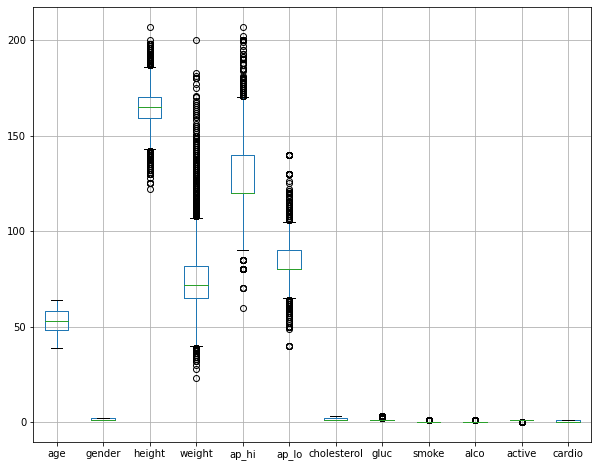

In [62]:
train_data.boxplot(figsize=(10,8))

In [63]:
test_data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,51,1,154,85.0,130,80.0,1,1,0,0,1
1,52,2,170,69.0,130,90.0,1,1,0,0,1
2,55,1,160,70.0,120,75.0,1,1,0,0,0
3,49,2,185,94.0,130,90.0,1,1,0,0,1
4,44,2,170,76.0,120,80.0,1,1,0,0,1


# Modeling #

In [64]:
features_train = train_data.drop('cardio', axis=1)
target_train = train_data['cardio']

RANDOM_SCORE = 69

In [65]:
test_data

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,51,1,154,85.0,130,80.0,1,1,0,0,1
1,52,2,170,69.0,130,90.0,1,1,0,0,1
2,55,1,160,70.0,120,75.0,1,1,0,0,0
3,49,2,185,94.0,130,90.0,1,1,0,0,1
4,44,2,170,76.0,120,80.0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
29995,59,2,170,103.0,150,90.0,1,1,0,1,0
29996,50,1,172,78.0,110,70.0,1,1,0,0,1
29997,58,2,169,61.0,120,80.0,1,1,0,0,0
29998,39,2,175,80.0,120,80.0,2,1,0,0,0


In [66]:
%%time

best_score_tree = 0
best_depth_tree = 0

for depth in range(1, 100, 1):
    tree_model = DecisionTreeClassifier(max_depth = depth, random_state = RANDOM_SCORE)
    tree_model.fit(features_train, target_train)
    
    #tree_pred = tree_model.predict(features_valid)
    #tree_score = accuracy_score(target_valid, tree_pred)
    tree_cvs = cross_val_score(tree_model, features_train, target_train, cv=4, scoring='roc_auc').mean()
    
    if tree_cvs > best_score_tree:
        best_score_tree = tree_cvs
        best_depth_tree = depth

print(tree_cvs)
print(best_depth_tree)

0.6373437417129505
6
CPU times: total: 1min 15s
Wall time: 1min 15s


In [67]:
# constructing model with previous best hyperparameters
model_tree = DecisionTreeClassifier(max_depth=best_depth_tree, random_state=RANDOM_SCORE)
model_tree.fit(features_train, target_train)
    
predicted_tree = model_tree.predict(test_data)

# calculating accuracy, precision, recall and f-score
#tree_score = accuracy_score(target_test, predicted_tree)
#precision_tree = precision_score(target_test, predicted_tree)
#recall_tree = recall_score(target_test, predicted_tree)
#f_score_tree = f1_score(target_test, predicted_tree)

print(predicted_tree)

[0 1 0 ... 0 0 1]


In [68]:
%%time

best_forest_score = 0
best_forest_est = 0
best_forest_depth = 0

for est in range(1, 30, 1):
    for depth in range(1, 25, 1):
        forest_model = RandomForestClassifier(max_depth = depth, n_estimators = est, random_state = RANDOM_SCORE)
        forest_model.fit(features_train, target_train)
    
        #forest_pred = forest_model.predict(features_valid)
        #forest_score = accuracy_score(target_valid, forest_pred)
        forest_cvs = cross_val_score(forest_model, features_train, target_train, cv=4, scoring='roc_auc').mean()
    
        if forest_cvs > best_forest_score:
            best_forest_score = forest_cvs
            best_forest_est = est
            best_forest_depth = depth
            
print('Best accuracy for RF:', best_forest_score)
print('Best depth for RF:', best_forest_depth)
print('Best est for RF:', best_forest_est)
print('')

Best accuracy for RF: 0.8016089640565043
Best depth for RF: 9
Best est for RF: 29

CPU times: total: 21min 26s
Wall time: 21min 41s


In [69]:
best_forest_model = RandomForestClassifier(max_depth = 9, n_estimators = 29, random_state = RANDOM_SCORE)
best_forest_model.fit(features_train, target_train)

best_forest_cvs = cross_val_score(best_forest_model, features_train, target_train, cv=4, scoring='roc_auc').mean()

print(best_forest_cvs)

0.8016089640565043


In [71]:
lr_model = LogisticRegression(max_iter=100, solver='liblinear', random_state=RANDOM_SCORE)
lr_model.fit(features_train, target_train)

lr_cvs = cross_val_score(lr_model, features_train, target_train, scoring='roc_auc', cv=4).mean()

print(lr_cvs)

0.7934118759747122


# Total classification #

In [ ]:
filename = 'D:/sample_submission.csv'
joblib.dump(subsample, filename)

# Conclusion #

In [ ]:
subsample['cardio'] = best_forest_model.predict(test_data)
subsample

In [ ]:
subsample.to_csv('D:/sample_submission.csv', index=False)

In [ ]:
y = pd.read_csv('D:/sample_submission.csv')
y